## Load Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

## Define Global Variables

In [2]:
window = 12*21
backtest_period = (12*21) * 2 - 1
backtest_period_year = '2y'
NUMBER_PER_LEG = 10

## Define the investment universe 

In [3]:
# Fetch the list of S&P 500 companies from Wikipedia.
sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
tickers = sp500_tickers['Symbol'].tolist()

## Signals Definition

### 12m Momentum

In [4]:
def get_12m_momentum(assets, window=12*21):
    frames = []
    for asset in assets:
        data = yf.download(asset, period=backtest_period_year, interval='1d', progress=False)['Adj Close']
        if data.count() < backtest_period:
            continue
        shifted_data = data.shift(21)
        mom_signal = np.log(shifted_data / shifted_data.shift(window))
        frames.append(mom_signal.dropna().to_frame(asset))
    return pd.concat(frames, axis=1)

### 12m Momentum HTP (by using P0)

In [5]:
def get_12m_htp_momentum_P0(assets, window=12*21):
    frames = []
    for asset in assets:
        data = yf.download(asset, period=backtest_period_year, interval='1d', progress=False)['Adj Close']
        if data.count() < backtest_period:
            continue
        shifted_data = data.shift(21)
        p_max = shifted_data.rolling(window).max()
        htp = np.log(p_max/shifted_data.shift(window))
        frames.append(htp.dropna().to_frame(asset))
    return pd.concat(frames, axis=1)

### 6m Consistency

In [6]:
# Consistency: Number of days with positive returns (historical 6m to 1m window)
def get_6m_consistency(assets, window = 6*21):
    frames = []
    for asset in assets:
        data = yf.download(asset, period=backtest_period_year, interval='1d', progress=False)['Adj Close']
        if data.count() < backtest_period:
            continue
        shifted_data = data.shift(21)
        rets = np.log(shifted_data/shifted_data.shift(1))
        consistency = (rets.rolling(window=window,min_periods=window).agg(lambda x: (x > 0).sum()))
        frames.append(consistency.dropna().to_frame(asset))
    return pd.concat(frames, axis=1)

### 6m Confirmation

In [7]:
# Sum of daily returns (historical 6m to 1m window)
def get_6m_confirmation(assets, window = 6*21):
    frames = []
    for asset in assets:
        data = yf.download(asset, period=backtest_period_year, interval='1d', progress=False)['Adj Close']
        if data.count() < backtest_period:
            continue
        shifted_data = data.shift(21)
        rets = np.log(shifted_data/shifted_data.shift(1))
        confirmation = rets.rolling(window=window).sum()
        frames.append(confirmation.dropna().to_frame(asset))
    return pd.concat(frames, axis=1)

### 6m Highest Price Factor

In [8]:
# Current price/price high reached in historical 6m to 1m window
def get_6m_highest_price_factor(assets, window = 6*21):
    frames = []
    for asset in assets:
        data = yf.download(asset, period=backtest_period_year, interval='1d', progress=False)['Adj Close']
        if data.count() < backtest_period:
            continue
        shifted_data = data.shift(21)
        highest_price_factor = shifted_data / shifted_data.rolling(window).max()
        frames.append(highest_price_factor.dropna().to_frame(asset))
    return pd.concat(frames, axis=1)

### Enhanced Momentum Signals (Barclays Paper)

In [9]:
def get_BARC_momentum(df_macro_signal, df_consistency, df_confirmation, df_highest_price_factor):
    df_macro_signal_ranks = df_macro_signal.rank(1, ascending=True, method='first')
    df_consistency_ranks = df_consistency.rank(1, ascending=True, method='first')
    df_confirmation_ranks = df_confirmation.rank(1, ascending=True, method='first')
    df_highest_price_factor_ranks = df_highest_price_factor.rank(1, ascending=True, method='first')
    persistency_signal = 1/3 * (df_consistency_ranks + df_confirmation_ranks + df_highest_price_factor_ranks)
    BARC_momentum = 1/2 * (df_macro_signal_ranks + persistency_signal).dropna()
    return BARC_momentum

### Defining signals DF

In [10]:
df_macro_signal = get_12m_momentum(tickers).dropna(axis=1)
df_htp_P0 = get_12m_htp_momentum_P0(tickers).dropna(axis=1)
df_consistency = get_6m_consistency(tickers).dropna(axis=1)
df_confirmation = get_6m_confirmation(tickers).dropna(axis=1)
df_highest_price_factor = get_6m_highest_price_factor(tickers).dropna(axis=1)


1 Failed download:
['BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')

1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=2y)')

1 Failed download:
['BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')

1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=2y)')

1 Failed download:
['BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')

1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=2y)')

1 Failed download:
['BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')

1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=2y)')

1 Failed download:
['BRK.B']: Exception('%ticker%: No data found, symbol may be delisted')

1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (period=2

In [11]:
# Enhanced Momentum coupled with HTP P0
BARC_momentum = get_BARC_momentum(df_macro_signal, df_consistency, df_confirmation, df_highest_price_factor)
BARC_momentum_P0 = 1/2 * (BARC_momentum + df_htp_P0.rank(1, ascending=True, method='first'))

### Convert signals DF into Winners and Losers

In [12]:
def convert_to_winners_signals_df(signal_df, n_winners):
    # Find the n largest values for each row (date)
    signal_df_w = signal_df.apply(pd.Series.nlargest, axis=1, n=n_winners)

    missing_columns = [col for col in signal_df.columns if col not in signal_df_w.columns]
    nan_df = pd.DataFrame(np.nan, index=signal_df.index, columns=missing_columns)
    signal_df_w = pd.concat([signal_df_w, nan_df], axis=1)
    signal_df_w = signal_df_w[signal_df.columns]
    signal_df_w_f = signal_df_w.notnull().astype(int)
    signal_df_w_f_weighted = signal_df_w_f.multiply(1 / n_winners, axis=0)
    
    return signal_df_w_f_weighted    

In [13]:
signal_df_barc_P0 = convert_to_winners_signals_df(BARC_momentum_P0, NUMBER_PER_LEG)

## Backtesting

In [14]:
def convert_signal_to_portfolio(signal_df):
    frames = []
    for asset in signal_df.columns:
        data = yf.download(asset, period=backtest_period_year, interval='1d', progress=False)['Adj Close']
        frames.append(data.to_frame(asset))
    price_df = pd.concat(frames, axis=1)
    returns_df = np.log1p(price_df.pct_change()).dropna()
    returns_df = (returns_df[returns_df.index.isin(signal_df.index)])[signal_df.columns]
    
    portfolio_df = (signal_df * returns_df).dropna()    
    portfolio_df = pd.concat([portfolio_df, portfolio_df.sum(axis=1).rename('PORTFOLIO_RETURNS')], axis=1)
    return portfolio_df

In [15]:
portfolio_df = convert_signal_to_portfolio(signal_df_barc_P0)

In [16]:
def add_benchmark(df):
    # Download historical data
    spy_data = yf.download('SPY', period=backtest_period_year, interval='1d', progress=False)['Adj Close']
    spy_data = np.log1p(spy_data.pct_change()).dropna()    
    df['BENCHMARK'] = spy_data[spy_data.index.isin(df.index)]
    return df

In [17]:
portfolio_df = add_benchmark(portfolio_df)

### PLOT PERFORMANCE

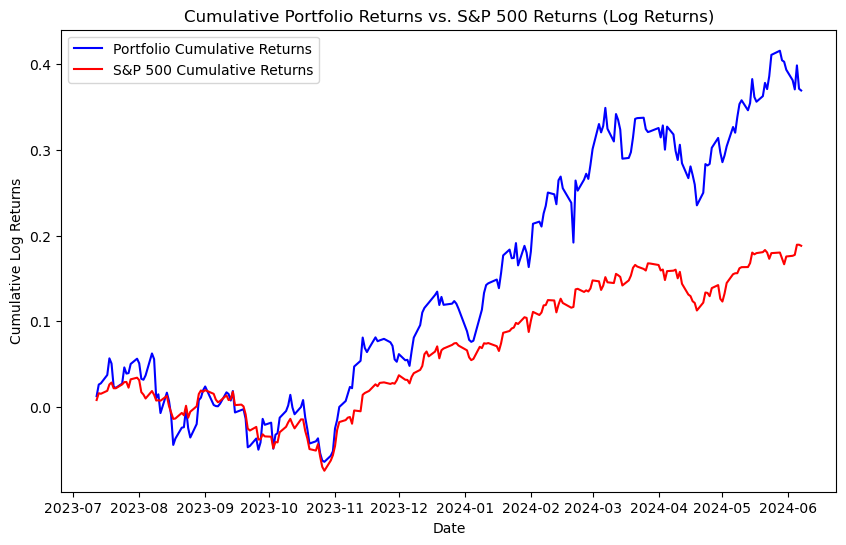

In [18]:
# Calculate cumulative returns
cumulative_portfolio_returns = portfolio_df['PORTFOLIO_RETURNS'].cumsum()
cumulative_spy_returns = portfolio_df['BENCHMARK'].cumsum()

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(cumulative_portfolio_returns.index, cumulative_portfolio_returns, label='Portfolio Cumulative Returns', color='blue')
plt.plot(cumulative_spy_returns.index, cumulative_spy_returns, label='S&P 500 Cumulative Returns', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Cumulative Log Returns')
plt.title('Cumulative Portfolio Returns vs. S&P 500 Returns (Log Returns)')
plt.legend()

# Show plot
plt.show()